### Libraries and Modules

In [1]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage import io, restoration, filters#, feature
from PIL import Image
from ipywidgets import interact, widgets


# Modules
from RICM_VESICLE import RICM
from FITTING import Fit_Gaussian

# Functions
def avg_movie(movie, l=2, show_dim=True):
    
    # Average each l frames
    movie_consecutive = []
    for i in range(int(movie.shape[0])):
        if movie.shape[0] - i >= l:
            movie_consecutive.append(np.mean(movie[i:i+l], axis=0))

    # Transform the movie into numpy array
    movie_consecutive = np.array(movie_consecutive)
    
    # Show the dimension reduction
    if show_dim == True:
        print("{} --> {}".format(movie.shape, movie_consecutive.shape))
    
    return movie_consecutive

### Determine the Movie

In [2]:
# Determine the Shot and th GUV number
SHOT, GUV = "", 1

### Read the whole RICM image to determine the base line

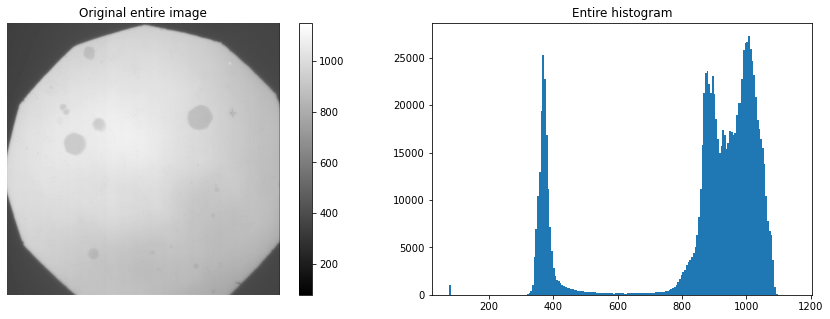

In [4]:
# Read the RICM image
RICM_img = io.imread("20210112_Ecad_dynamics/data/movie-550ms-200-1sec-1200_232_1200.tif")[200:2600].mean(axis = 0)

# display the image and it's histogram
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.axis('off')
plt.title('Original entire image')
plt.imshow(RICM_img, cmap = "gray")
plt.colorbar()

plt.subplot(122)
plt.title('Entire histogram')
plt.hist(RICM_img.ravel(), bins = 200);
#plt.xlim(290,1200);

### Read the RICM image for one GUV

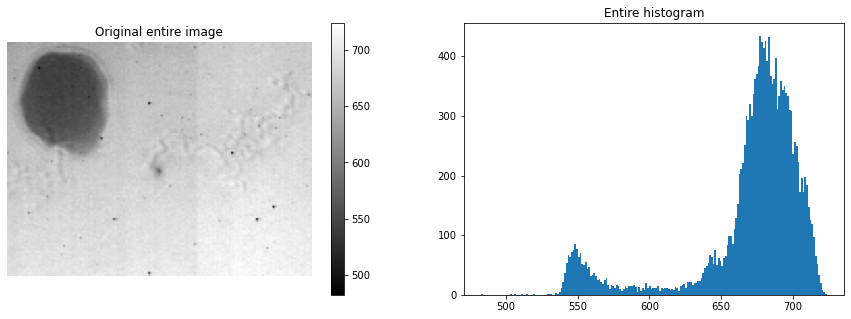

In [12]:
# Read the image
guv = io.imread("20210112_Ecad_dynamics/data/movie-550ms-200-1sec-1200_232_1200{}-{}.tif".format(SHOT, GUV))[620:2600, 5:]

# Subtract the base line
guv = guv - 310

# Take the average
guv_avg = guv.mean(axis = 0)

# display the image and it's histogram
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.axis('off')
plt.title('Original entire image')
plt.imshow(guv_avg, cmap = "gray")
plt.colorbar()

plt.subplot(122)
plt.title('Entire histogram')
plt.hist(guv_avg.ravel(), bins = 200);

### Define the RICM model to get the bacground corrected image

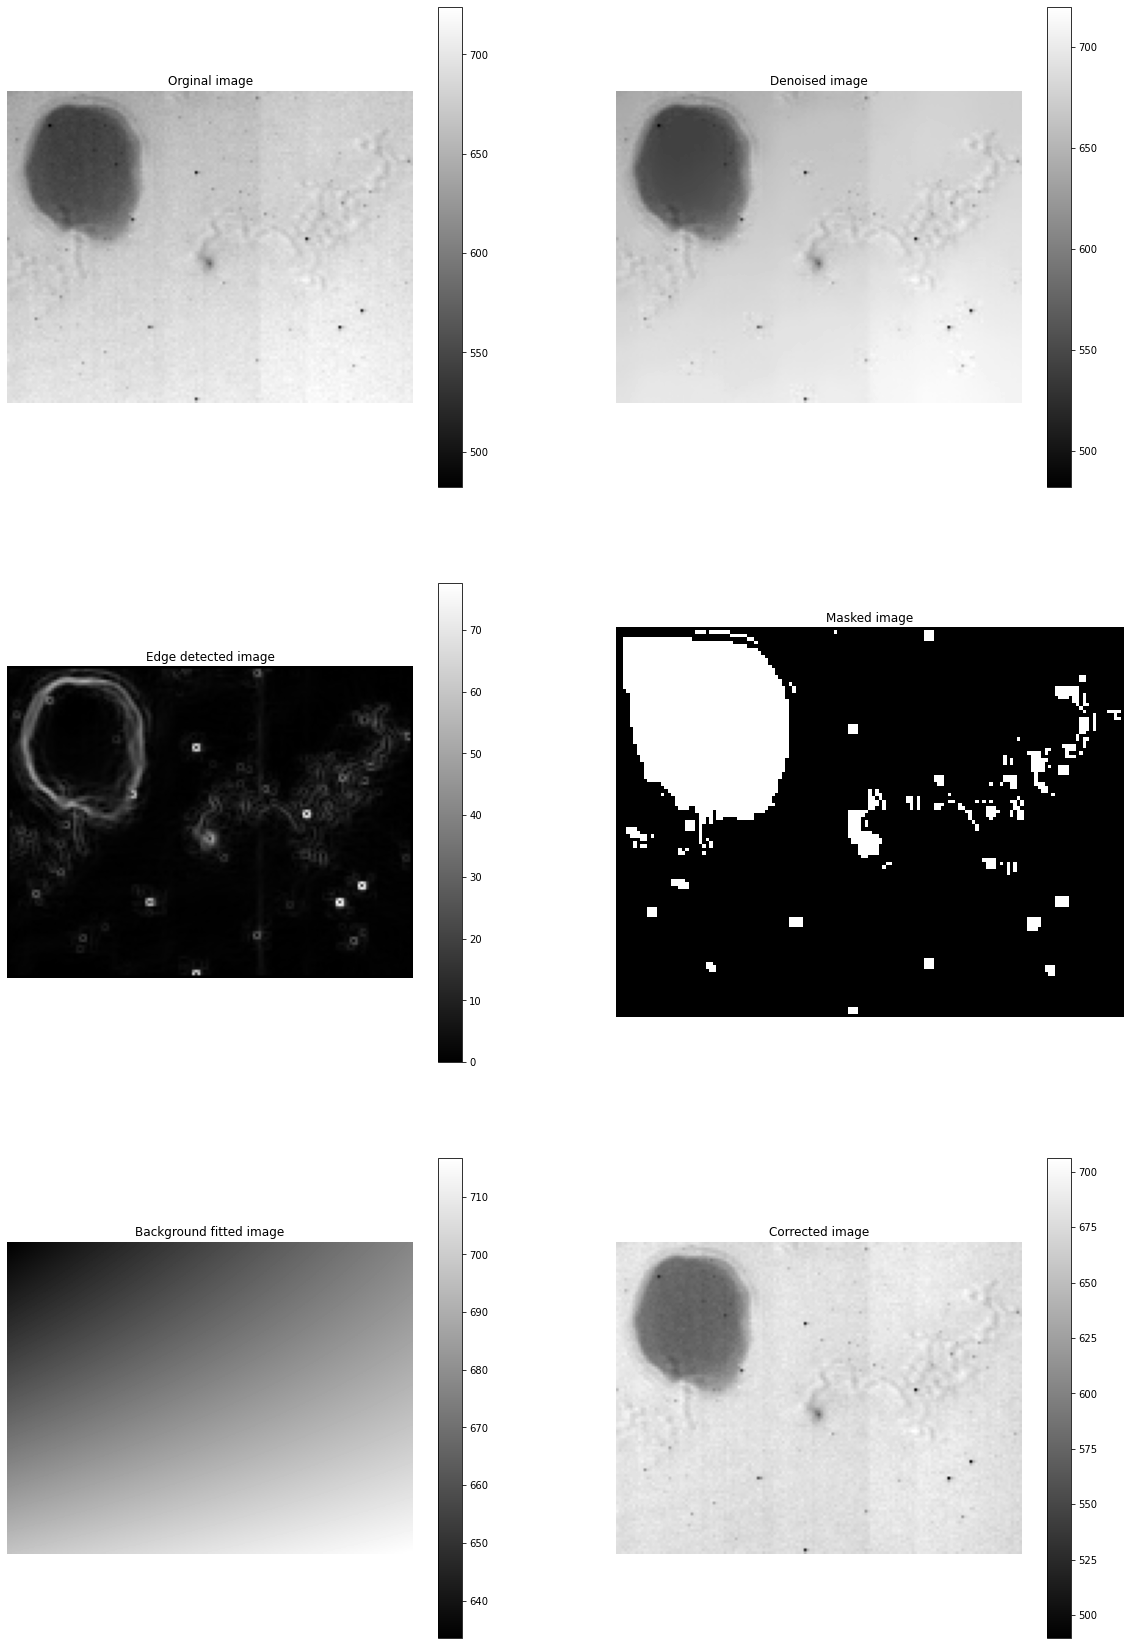

In [13]:
# Define the RICM class with certain n_inner
ricm = RICM(guv_avg, n_inner = 1.344, hole = 2)

# display results
plt.figure(figsize=(20,30))

plt.subplot(321)
plt.axis('off')
plt.title('Orginal image')
plt.imshow(guv_avg, cmap = "gray")
plt.colorbar()

plt.subplot(322)
plt.axis('off')
plt.title('Denoised image')
plt.imshow(ricm.nl_denoise() , cmap = 'gray')
plt.colorbar()

plt.subplot(323)
plt.axis('off')
plt.title('Edge detected image')
plt.imshow(ricm.edge_detection() , cmap = 'gray')
plt.colorbar()

plt.subplot(324)
plt.axis('off')
plt.title('Masked image')
plt.imshow(ricm.mask() , cmap = 'gray')

plt.subplot(325)
plt.axis('off')
plt.title('Background fitted image')
plt.imshow(ricm.background_fitting() , cmap = 'gray')
plt.colorbar()

plt.subplot(326)
plt.axis('off')
plt.title('Corrected image')
plt.imshow(ricm.correct() , cmap = 'gray')
plt.colorbar();

### Take a cosecutive average of the GUV movie

In [14]:
# Take a cosecutive average
guv_consecutive = avg_movie(guv, l=6)

(1980, 113, 147) --> (1975, 113, 147)


In [15]:
%%time

# Define the RICM class with certain n_inner
ricm = RICM(guv_avg, n_inner = 1.344, hole = 2)

# Define the background
background = ricm.background_fitting()
background_correction = background.mean() - background

# Estimating the noise variance of the image
sigma_est = np.mean(restoration.estimate_sigma(guv_consecutive[-1] , multichannel = False))

# Get the area of each frame in the averaged movie
area = []
for i in range(guv_consecutive.shape[0]):

    # Apply the Non-local means denoising algorithm
    img_denoised = restoration.denoise_nl_means(guv_consecutive[i],
                                                h = sigma_est,
                                                fast_mode = True,
                                                patch_size = 10,
                                                patch_distance = 20,
                                                multichannel = False)
    
    # Correct the background 
    img_corrected = img_denoised + background_correction

    # Compute the area
    area.append((1 - np.multiply(img_corrected > filters.threshold_otsu(img_corrected), 1)).sum())

# Transform the area into normalized numpy array
area = np.array(area)
#area = area/area.max()

CPU times: user 9min 2s, sys: 23.4 ms, total: 9min 2s
Wall time: 9min 1s


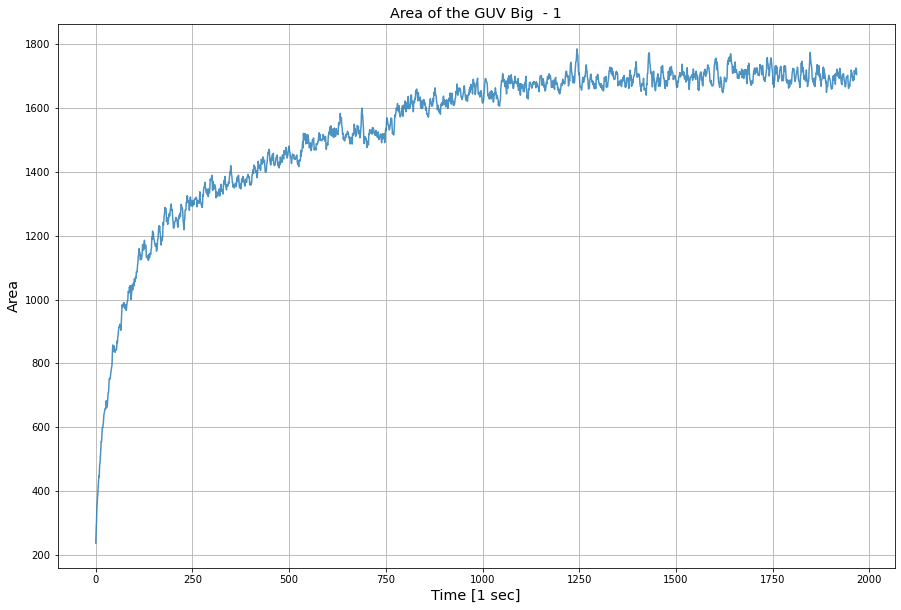

In [22]:
# Define the curve
curve = area[7:]

# Plot the curve
plt.figure(figsize=(15, 10))

plt.plot(curve, label = '{}_{}'.format(SHOT, GUV), alpha = 0.8)
plt.title('Area of the GUV Big {} - {}'.format(SHOT, GUV), fontsize= 'x-large')
plt.xlabel('Time [1 sec]', fontsize = "x-large")
plt.ylabel('Area', fontsize = "x-large")
plt.grid()
#plt.savefig("20210112_Ecad_dynamics/results/550ms-200{}-{}".format(SHOT, GUV))

# Save the data
#np.save("20210112_Ecad_dynamics/results/550ms-200{}-{}".format(SHOT, GUV), curve)
#np.save("20210112_Ecad_dynamics/results/1sec-1200_232_1200{}-{}_till250".format(SHOT, GUV), curve)

In [23]:
time_gap = np.linspace(np.mean(area[750:780]),np.mean(area[780:810]),232)

area_big_modefied = np.concatenate((area[7:780], time_gap, area[781:]))

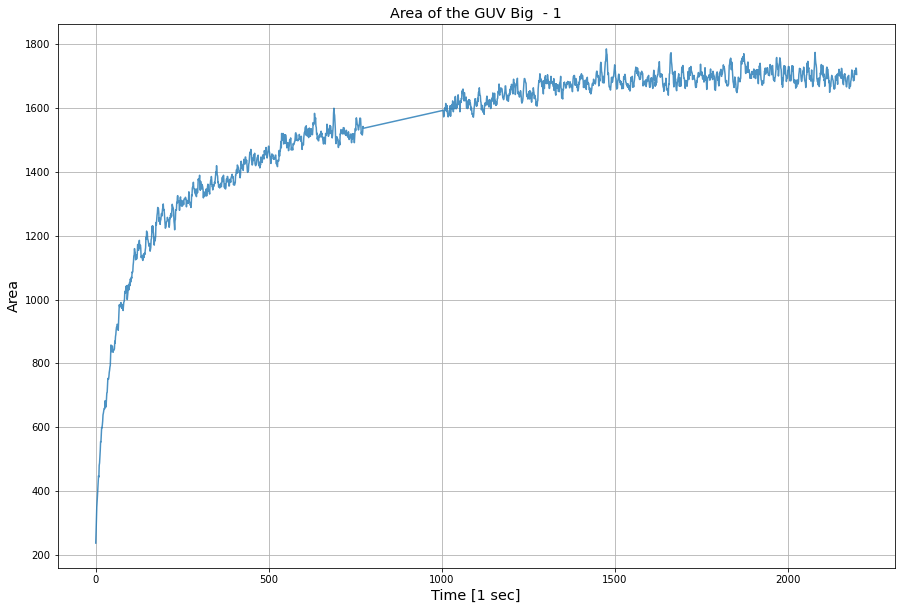

In [25]:
# Define the curve
curve = area_big_modefied[0:]

# Plot the curve
plt.figure(figsize=(15, 10))

plt.plot(curve, label = '{}_{}'.format(SHOT, GUV), alpha = 0.8)
plt.title('Area of the GUV Big {} - {}'.format(SHOT, GUV), fontsize= 'x-large')
plt.xlabel('Time [1 sec]', fontsize = "x-large")
plt.ylabel('Area', fontsize = "x-large")
plt.grid()
plt.savefig("20210112_Ecad_dynamics/results/1sec-780_232_1200{}-{}".format(SHOT, GUV))
#plt.savefig("20210112_Ecad_dynamics/results/1sec-1200_232_1200{}-{}_till250".format(SHOT, GUV))

# Save the data
np.save("20210112_Ecad_dynamics/results/1sec-780_232_1200{}-{}".format(SHOT, GUV), curve)
#np.save("20210112_Ecad_dynamics/results/1sec-1200_232_1200{}-{}_till250".format(SHOT, GUV), curve)

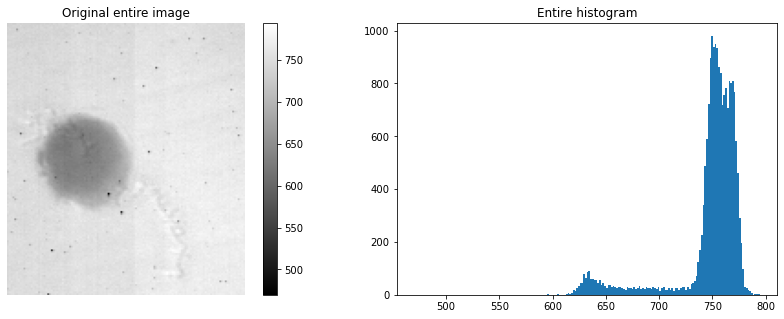

In [41]:
# Read the image
guv = io.imread("20210112_Ecad_dynamics/data/movie-550ms-200-1sec-1200_232_1200{}-{}.tif".format(SHOT, GUV))[200:2600]

# Subtract the base line
guv = guv - 310

# Take the average
guv_avg = guv.mean(axis = 0)

# Take the average
guv_avg = guv.mean(axis = 0)

# display the image and it's histogram
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.axis('off')
plt.title('Original entire image')
plt.imshow(guv_avg, cmap = "gray")
plt.colorbar()

plt.subplot(122)
plt.title('Entire histogram')
plt.hist(guv_avg.ravel(), bins = 200);

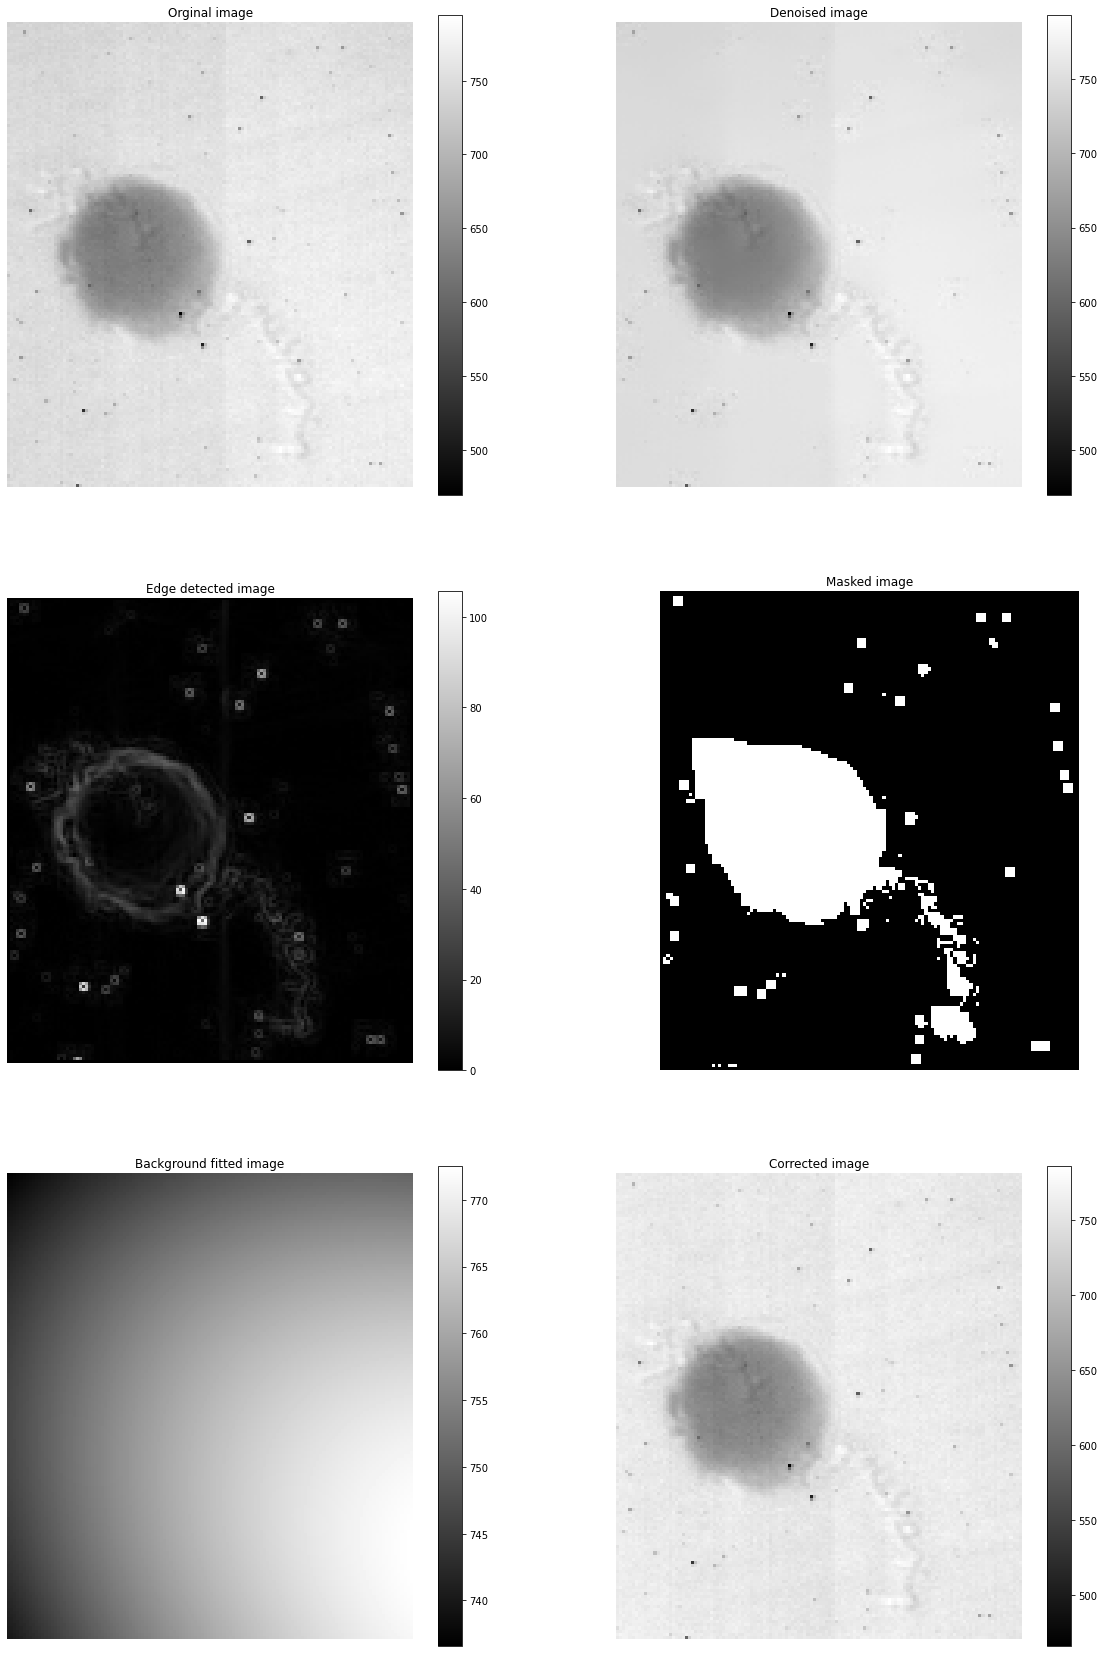

In [43]:
# Define the RICM class with certain n_inner
ricm = RICM(guv_avg, n_inner = 1.344, hole = 2)

# display results
plt.figure(figsize=(20,30))

plt.subplot(321)
plt.axis('off')
plt.title('Orginal image')
plt.imshow(guv_avg, cmap = "gray")
plt.colorbar()

plt.subplot(322)
plt.axis('off')
plt.title('Denoised image')
plt.imshow(ricm.nl_denoise() , cmap = 'gray')
plt.colorbar()

plt.subplot(323)
plt.axis('off')
plt.title('Edge detected image')
plt.imshow(ricm.edge_detection() , cmap = 'gray')
plt.colorbar()

plt.subplot(324)
plt.axis('off')
plt.title('Masked image')
plt.imshow(ricm.mask() , cmap = 'gray')

plt.subplot(325)
plt.axis('off')
plt.title('Background fitted image')
plt.imshow(ricm.background_fitting() , cmap = 'gray')
plt.colorbar()

plt.subplot(326)
plt.axis('off')
plt.title('Corrected image')
plt.imshow(ricm.correct() , cmap = 'gray')
plt.colorbar();

In [45]:
# Take a cosecutive average
guv_consecutive = avg_movie(guv, l=6)

(2400, 149, 130) --> (2395, 149, 130)


In [46]:
%%time

# Define the RICM class with certain n_inner
#ricm = RICM(guv_avg, n_inner = 1.344, hole = 3)

# Define the background
#background = ricm.background_fitting()
#background_correction = background.mean() - background

# Estimating the noise variance of the image
sigma_est = np.mean(restoration.estimate_sigma(guv_consecutive[-1] , multichannel = False))

# Get the area of each frame in the averaged movie
area_big = []
for i in range(guv_consecutive.shape[0]):

    # Apply the Non-local means denoising algorithm
    img_denoised = restoration.denoise_nl_means(guv_consecutive[i],
                                                h = sigma_est,
                                                fast_mode = True,
                                                patch_size = 10,
                                                patch_distance = 20,
                                                multichannel = False)
    
    # Correct the background 
    img_corrected = img_denoised + background_correction

    # Compute the area
    area_big.append((1 - np.multiply(img_corrected > filters.threshold_otsu(img_corrected), 1)).sum())

# Transform the area into normalized numpy array
area_big = np.array(area_big)
#area_big = area_big/area_big.max()

CPU times: user 12min 4s, sys: 4.18 ms, total: 12min 4s
Wall time: 12min 4s


In [47]:
time_gap = np.linspace(np.mean(area_big[1150:1199]),np.mean(area_big[1200:1250]),232)

area_big_modefied = np.concatenate((area_big[:1200], time_gap, area_big[1200:]))

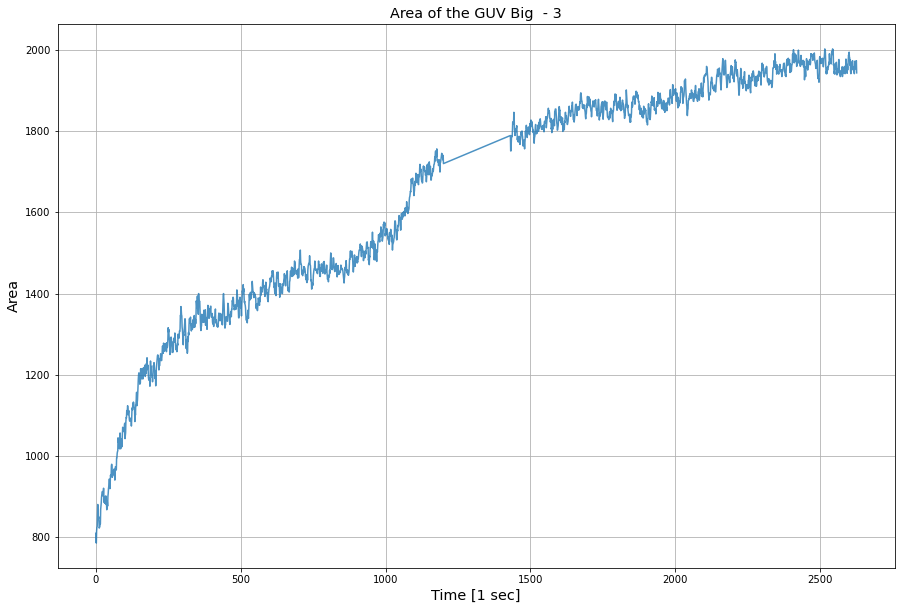

In [48]:
# Define the curve
curve = area_big_modefied[0:]

# Plot the curve
plt.figure(figsize=(15, 10))

plt.plot(curve, label = '{}_{}'.format(SHOT, GUV), alpha = 0.8)
plt.title('Area of the GUV Big {} - {}'.format(SHOT, GUV), fontsize= 'x-large')
plt.xlabel('Time [1 sec]', fontsize = "x-large")
plt.ylabel('Area', fontsize = "x-large")
plt.grid()
#plt.savefig("20210112_Ecad_dynamics/results/1sec-1200_232_1200{}-{}".format(SHOT, GUV))
#plt.savefig("20210112_Ecad_dynamics/results/1sec-1200_232_1200{}-{}_till250".format(SHOT, GUV))

# Save the data
#np.save("20210112_Ecad_dynamics/results/1sec-1200_232_1200{}-{}".format(SHOT, GUV), curve)
#np.save("20210112_Ecad_dynamics/results/1sec-1200_232_1200{}-{}_till250".format(SHOT, GUV), curve)

In [49]:
area_res= np.array([(area[i]+area[i+1])/2 for i in range(0, len(area)-1, 2)])

area_res.shape

(67,)

In [50]:
area_tot = np.concatenate((area_res, area_big))

area_tot.shape

(2462,)

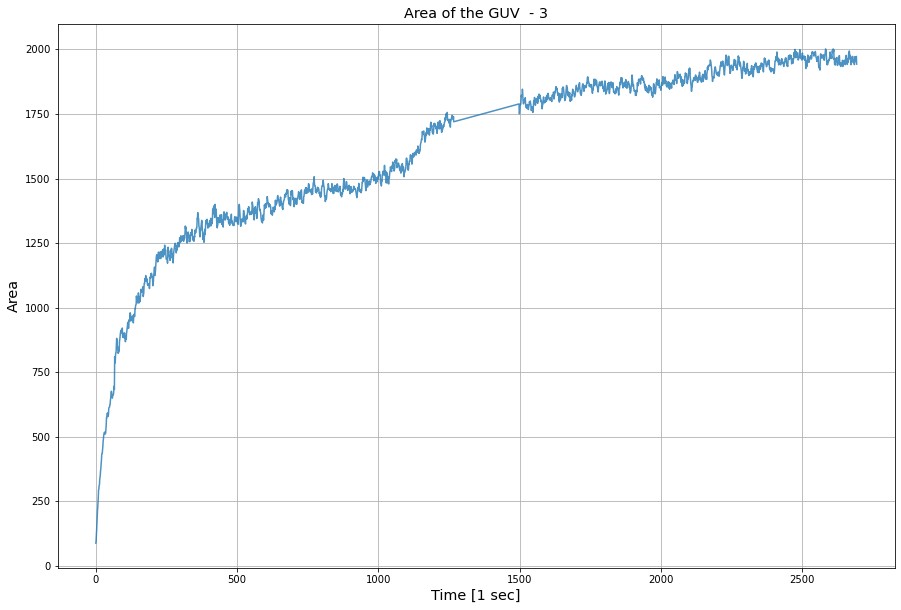

In [51]:
# Resize the first array
area_res= np.array([(area[i]+area[i+1])/2 for i in range(0, len(area)-1, 2)])

# Concatenate the two arrays
area_tot = np.concatenate((area_res, area_big_modefied))

# Plot the curve
plt.figure(figsize=(15, 10))

plt.plot(area_tot[:], label = '{}_{}'.format(SHOT, GUV), alpha = 0.8)
plt.title('Area of the GUV {} - {}'.format(SHOT, GUV), fontsize= 'x-large')
plt.xlabel('Time [1 sec]', fontsize = "x-large")
plt.ylabel('Area', fontsize = "x-large")
plt.grid()
plt.savefig("20210112_Ecad_dynamics/results/550ms-200-1sec-1200_232_1200{}-{}".format(SHOT, GUV))

# Save the data
np.save("20210112_Ecad_dynamics/results/550ms-200-1sec-1200_232_1200{}-{}".format(SHOT, GUV), area_tot[25:])
#np.save("20210112_Ecad_dynamics/results/1sec-1200_232_1200{}-{}_till250".format(SHOT, GUV), curve)

In [37]:
a = np.array([0,1,2])
b = np.array([3,4,5])
c = np.array([6,7,8])

np.concatenate((a,b,c))

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [42]:
time_gap = np.linspace(np.mean(area_big[1150:1199]),np.mean(area_big[1200:1250]),232)

(232,)

shot 2, GUV 0 not found
(200, 261, 274) --> (195, 261, 274)
shot 2, GUV 2 not found
shot 2, GUV 3 not found
shot 3, GUV 0 not found
(200, 348, 342) --> (195, 348, 342)
(200, 112, 115) --> (195, 112, 115)
(200, 111, 120) --> (195, 111, 120)
shot 4, GUV 0 not found
(200, 206, 214) --> (195, 206, 214)
(200, 209, 208) --> (195, 209, 208)
shot 4, GUV 3 not found
shot 5, GUV 0 not found
(200, 233, 223) --> (195, 233, 223)
(200, 149, 146) --> (195, 149, 146)
shot 5, GUV 3 not found
shot 6, GUV 0 not found
(255, 273) --> (250, 273)
shot 6, GUV 1 not found
(240, 243) --> (235, 243)
shot 6, GUV 2 not found
(171, 186) --> (166, 186)
shot 6, GUV 3 not found
shot 7, GUV 0 not found
(200, 276, 281) --> (195, 276, 281)
shot 7, GUV 2 not found
shot 7, GUV 3 not found


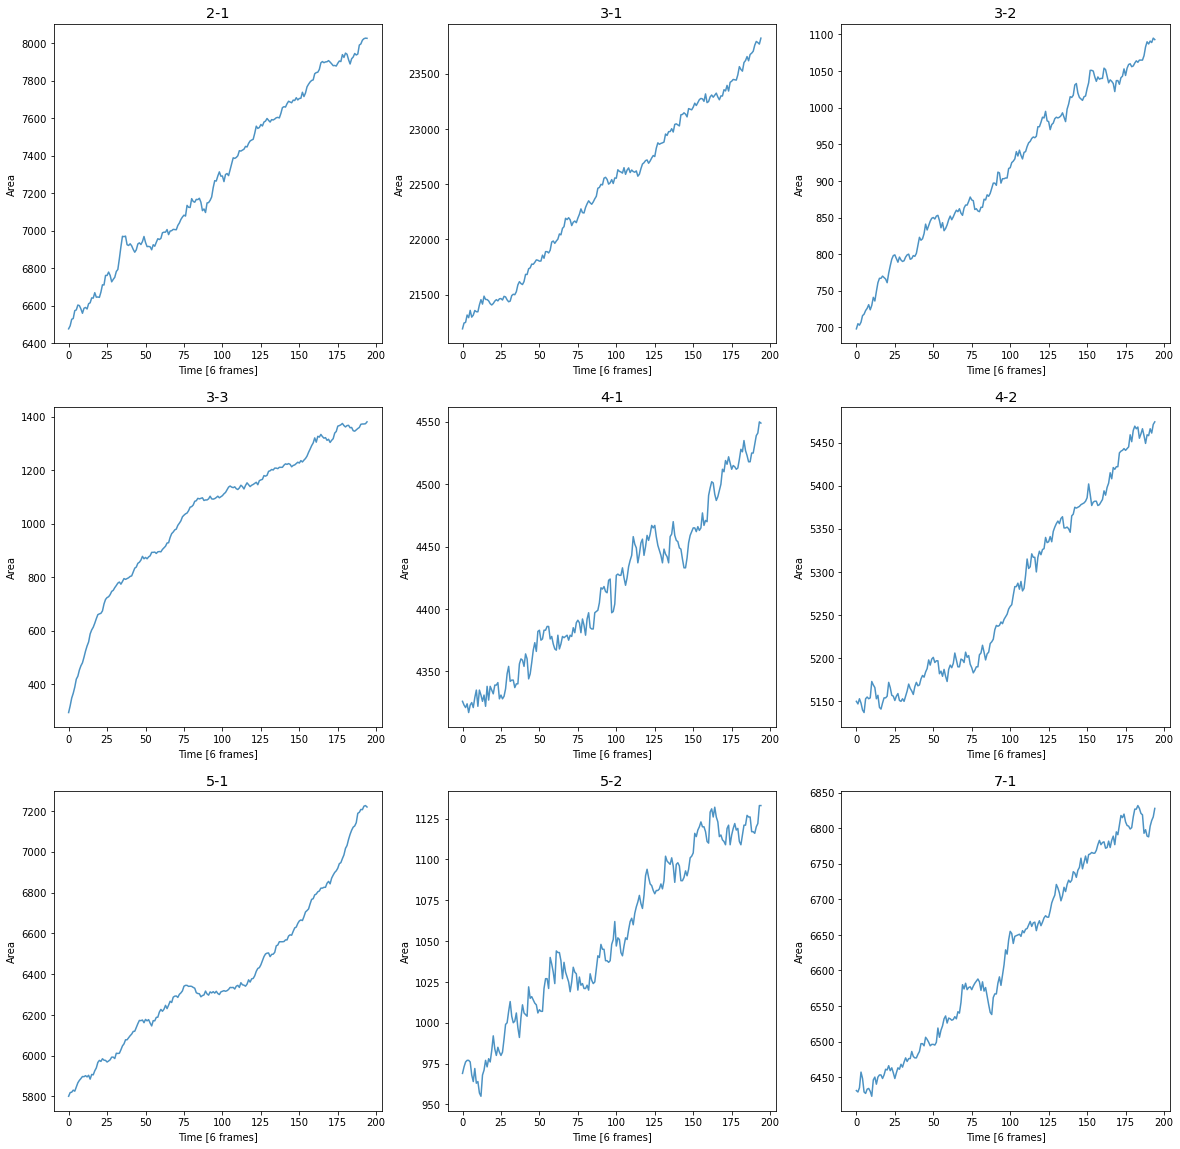

In [2]:
plt.figure(figsize=(20, 20))

z = 1
# Iterate on each Shot and GUV
for SHOT in range(2,8):
    for GUV in range(4):
        try:
            # Read the image
            guv = io.imread("20201216_Ecad_dynamics/data/Calib_camera{}-{}.tif".format(SHOT, GUV))

            # Subtract the base line
            guv = guv - 310

            # Take a cosecutive average of the movie
            guv_consecutive = avg_movie(guv, l=6)

            #Estimating the noise variance of the image
            sigma_est = np.mean(restoration.estimate_sigma(guv_consecutive[0] , multichannel = False))

            # Get the area of each frame in the averaged movie
            area = []
            for i in range(guv_consecutive.shape[0]):

                #Apply the Non-local means denoising algorithm
                img_denoised = restoration.denoise_nl_means(guv_consecutive[i], h = sigma_est,fast_mode = True,
                                                            patch_size = 10,
                                                            patch_distance = 20,
                                                            multichannel = False)

                # Compute the area
                area.append((1 - np.multiply(img_denoised > filters.threshold_otsu(img_denoised), 1)).sum())

            # Transform the area into normalized numpy array
            area = np.array(area)
            #area = area/area.max()

            # Plot the curve
            plt.subplot(3,3,z)
            plt.plot(area, label = '{}_{}'.format(SHOT, GUV), alpha = 0.8)
            plt.title('{}-{}'.format(SHOT, GUV), fontsize= 'x-large')
            plt.xlabel('Time [6 frames]')
            plt.ylabel('Area')
            
            # Change to the next subplot
            z += 1
            
        except:
            print('shot {}, GUV {} not found'.format(SHOT, GUV))

# Save the figure
plt.savefig('Area_individual_curves.png')
plt.show();

shot 2, GUV 0 not found
(200, 261, 274) --> (195, 261, 274)
shot 2, GUV 2 not found
shot 2, GUV 3 not found
shot 3, GUV 0 not found
(200, 348, 342) --> (195, 348, 342)
(200, 112, 115) --> (195, 112, 115)
(200, 111, 120) --> (195, 111, 120)
shot 4, GUV 0 not found
(200, 206, 214) --> (195, 206, 214)
(200, 209, 208) --> (195, 209, 208)
shot 4, GUV 3 not found
shot 5, GUV 0 not found
(200, 233, 223) --> (195, 233, 223)
(200, 149, 146) --> (195, 149, 146)
shot 5, GUV 3 not found
shot 6, GUV 0 not found
(255, 273) --> (250, 273)
shot 6, GUV 1 not found
(240, 243) --> (235, 243)
shot 6, GUV 2 not found
(171, 186) --> (166, 186)
shot 6, GUV 3 not found
shot 7, GUV 0 not found
(200, 276, 281) --> (195, 276, 281)
shot 7, GUV 2 not found
shot 7, GUV 3 not found


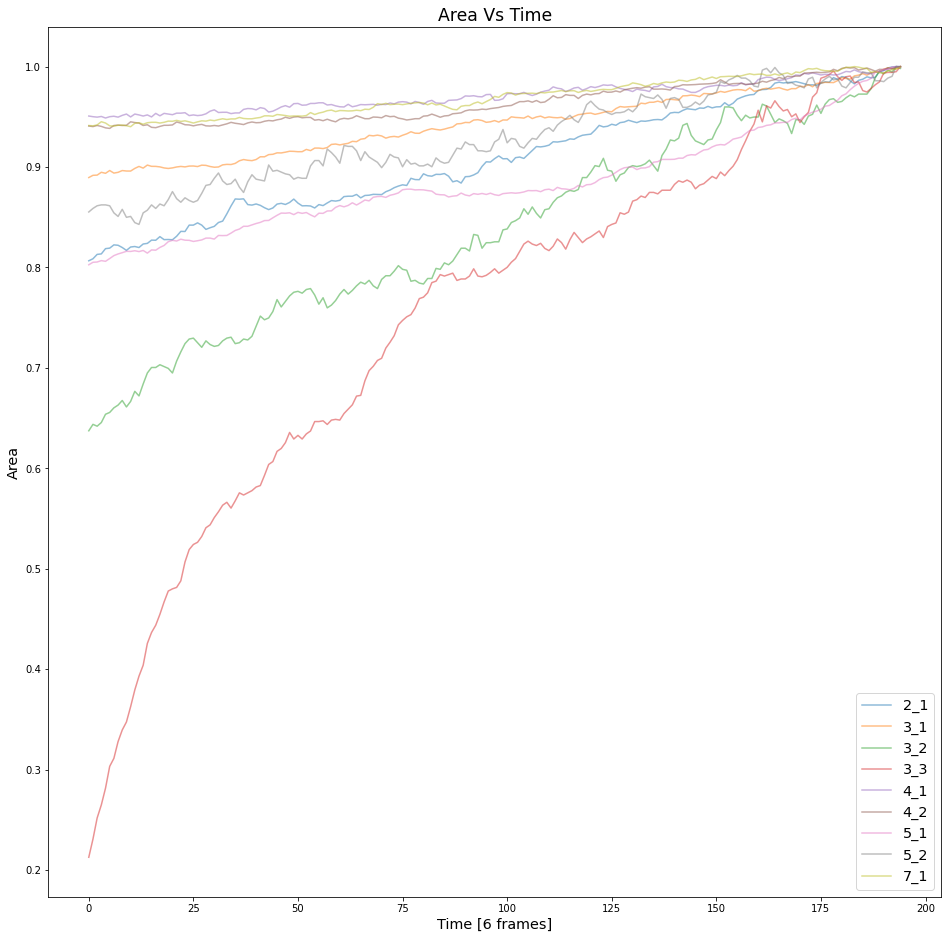

In [3]:
plt.figure(figsize=(16, 16))

# Iterate on each Shot and GUV
for SHOT in range(2,8):
    for GUV in range(4):
        try:
            # Read the image
            guv = io.imread("20201216_Ecad_dynamics/data/Calib_camera{}-{}.tif".format(SHOT, GUV))

            # Subtract the base line
            guv = guv - 310

            # Take a cosecutive average of the movie
            guv_consecutive = avg_movie(guv, l=6)

            #Estimating the noise variance of the image
            sigma_est = np.mean(restoration.estimate_sigma(guv_consecutive[0] , multichannel = False))

            # Get the area of each frame in the averaged movie
            area = []
            for i in range(guv_consecutive.shape[0]):

                #Apply the Non-local means denoising algorithm
                img_denoised = restoration.denoise_nl_means(guv_consecutive[i], h = sigma_est,fast_mode = True,
                                                            patch_size = 10,
                                                            patch_distance = 20,
                                                            multichannel = False)

                # Compute the area
                area.append((1 - np.multiply(img_denoised > filters.threshold_otsu(img_denoised), 1)).sum())

            # Transform the area into normalized numpy array
            area = np.array(area)
            area = area/area.max()

            # Plot the curve
            plt.plot(area, label = '{}_{}'.format(SHOT, GUV), alpha = 0.5)
        
        except:
            print('shot {}, GUV {} not found'.format(SHOT, GUV))

# Put the figure details
plt.title('Area Vs Time', fontsize= 'xx-large')
plt.xlabel('Time [6 frames]', fontsize= 'x-large')
plt.ylabel('Area', fontsize= 'x-large')
plt.legend(loc='lower right', fontsize= 'x-large')

# Save the figure
plt.savefig('Area_curves.png')
plt.show();

(2400, 149, 130) --> (2395, 149, 130)


<Figure size 1080x360 with 0 Axes>

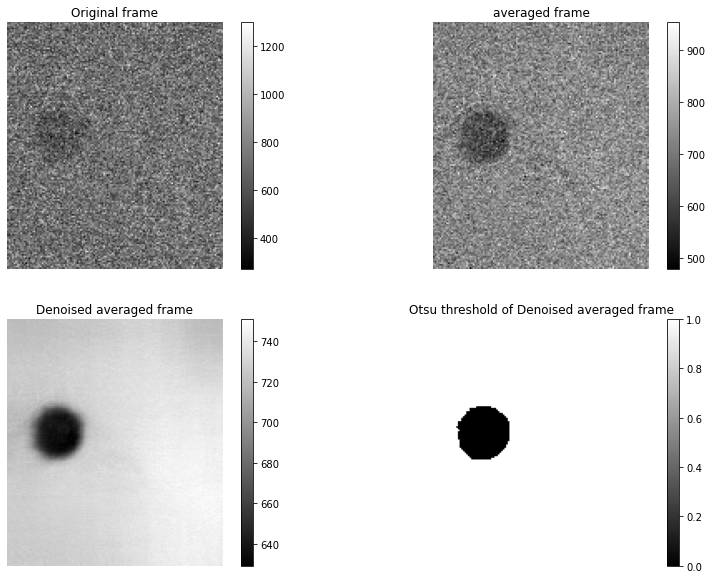

In [19]:
frame, L = 0, 6

# Take a cosecutive average of the movie
guv_consecutive = avg_movie(guv, l=L)

#Estimating the noise variance of the image
sigma_est = np.mean(restoration.estimate_sigma(guv_consecutive[0] , multichannel = False))

#Apply the Non-local means denoising algorithm
img_denoised = restoration.denoise_nl_means(guv_consecutive[frame], h = sigma_est,fast_mode = True,
                                            patch_size = 10,
                                            patch_distance = 20,
                                            multichannel = False)
# display the denoised image and it's histogram
plt.figure(figsize=(15,5))

# display the image and it's histogram
plt.figure(figsize=(14,10))

plt.subplot(221)
plt.axis('off')
plt.title('Original frame')
plt.imshow(guv[frame*L], cmap = "gray")
plt.colorbar()

plt.subplot(222)
plt.axis('off')
plt.title('averaged frame')
plt.imshow(guv_consecutive[frame], cmap = "gray")
plt.colorbar()
    
plt.subplot(223)
plt.axis('off')
plt.title('Denoised averaged frame')
plt.imshow(img_denoised, cmap = 'gray')
plt.colorbar()
    
plt.subplot(224)
plt.axis('off')
plt.title('Otsu threshold of Denoised averaged frame')
plt.imshow(np.multiply(img_denoised > filters.threshold_otsu(img_denoised), 1), cmap = 'gray')
plt.colorbar();

<Figure size 1080x360 with 0 Axes>

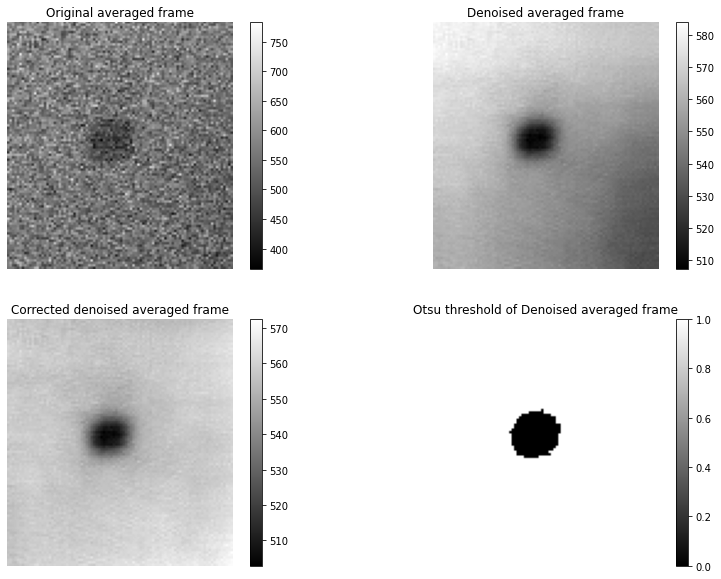

In [17]:
frame, L = 1500, 6

#Apply the Non-local means denoising algorithm
img_denoised = restoration.denoise_nl_means(guv_consecutive[frame], h = sigma_est,fast_mode = True,
                                            patch_size = 10,
                                            patch_distance = 20,
                                            multichannel = False)

# Apply the Non-local means denoising algorithm
img_denoised = restoration.denoise_nl_means(guv_consecutive[frame],
                                            h = sigma_est,
                                            fast_mode = True,
                                            patch_size = 10,
                                            patch_distance = 20,
                                            multichannel = False)
    
# Correct the background 
img_corrected = img_denoised + background_correction

# display the denoised image and it's histogram
plt.figure(figsize=(15,5))

# display the image and it's histogram
plt.figure(figsize=(14,10))

plt.subplot(221)
plt.axis('off')
plt.title('Original averaged frame')
plt.imshow(guv_consecutive[frame], cmap = "gray")
plt.colorbar()

plt.subplot(222)
plt.axis('off')
plt.title('Denoised averaged frame')
plt.imshow(img_denoised, cmap = "gray")
plt.colorbar()
    
plt.subplot(223)
plt.axis('off')
plt.title('Corrected denoised averaged frame')
plt.imshow(img_corrected, cmap = 'gray')
plt.colorbar()
    
plt.subplot(224)
plt.axis('off')
plt.title('Otsu threshold of Denoised averaged frame')
plt.imshow(np.multiply(img_corrected > filters.threshold_otsu(img_corrected), 1), cmap = 'gray')
plt.colorbar();